This is an illustration of a very simple generative adversarial network, built with TensorFlow. It generates images that look like handwritten digits from the MNIST dataset.

For the greatest possible clarity, I've adapted two well-documented networks as the discriminator and the generator. [The convolutional neural network from TensorFlow's documentation](https://www.tensorflow.org/tutorials/mnist/pros/) serves as the discriminator, and [Tim O'Shea's Keras model](http://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html) as the generator.

[Adit Deshpande](https://adeshpande3.github.io/) suggested a clever way to call the generator and discriminator as functions; his method is implemented below. Other crucial insights come from papers by [Ian Goodfellow](https://arxiv.org/abs/1701.00160) and [Alec Radford](https://arxiv.org/abs/1511.06434), and [Soumith Chintala](https://github.com/soumith/ganhacks).

**This is a work in progress**, and is full of all manner of hacks and hard-coded shortcuts that will disappear or (hopefully) become more elegant as I make revisions.

The code here is written for TensorFlow v0.12, but can be made to run on earlier versions with some quick changes—in particular, replacing `tf.global_variable_initializer()` with `tf.initialize_all_variables()`. This script sends very helpful output to TensorBoard; to make it work with TensorBoard v0.11 and earlier, replace `tf.summary.scalar()` and `tf.summary.image()` with `tf.scalar_summary()` and `tf.image_summary()`, respectively.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In a clever structure suggested by [Adit Deshpande](https://adeshpande3.github.io/), the discriminator and generator networks will sit inside separate functions that we can call as needed.

Here's the discriminator network. It takes `x_image` and returns a real/fake classification. As you'll see below, we can either feed `x_image` through a placeholder, or from another tensor—for instance, the output of the generator.

This network structure is taken directly from TensorFlow's [Deep MNIST for Experts](https://www.tensorflow.org/tutorials/mnist/pros/) tutorial.

In [2]:
def discriminator(x_image, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # These search for 32 different 5 x 5 pixel features
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=x_image, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Second convolutional and pool layers
    # These search for 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))

    # Final layer
    d4 = tf.matmul(d3, d_w4) + d_b4
    # d4 dimensions: batch_size x 1

    return d4

And here's the generator. When it's called, it starts by creating a batch of random noise from the latente space $z$, then passes it through a handful of convolutions to produce a 28 x 28 image.

This structure is borrowed [from Tim O'Shea](http://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html).

In [3]:
def generator(batch_size, z_dim):
    z = tf.truncated_normal([batch_size, z_dim], mean=0, stddev=1, name='z')
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # No batch normalization at the final layer, but we do add
    # a sigmoid activator to make the generated images crisper.
    # Dimensions of g4: batch_size x 28 x 28 x 1

    return g4

Here we set up our losses and optimizers.

In [4]:
sess = tf.Session()

batch_size = 50
z_dimensions = 100

x_placeholder = tf.placeholder("float", shape = [None,28,28,1], name='x_placeholder')
# x_placeholder is for feeding input images to the discriminator

Gz = generator(batch_size, z_dimensions)
# Gz holds the generated images

Dx = discriminator(x_placeholder)
# Dx hold the discriminator's prediction probabilities
# for real MNIST images

Dg = discriminator(Gz, reuse=True)
# Dg holds discriminator prediction probabilities for generated images

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(Dg, tf.ones_like(Dg)))

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(Dx, tf.fill([batch_size, 1], 0.9)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(Dg, tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

# Train the discriminator
# Increasing from 0.001 in GitHub version
d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list=d_vars)

# Train the generator
# Decreasing from 0.004 in GitHub version
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

Here's where we pass helpful summary scalars and sample images to TensorBoard.

In [5]:
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

d_real_count_ph = tf.placeholder(tf.float32)
d_fake_count_ph = tf.placeholder(tf.float32)
g_count_ph = tf.placeholder(tf.float32)

tf.summary.scalar('d_real_count', d_real_count_ph)
tf.summary.scalar('d_fake_count', d_fake_count_ph)
tf.summary.scalar('g_count', g_count_ph)

# Sanity check to see how the discriminator evaluates
# generated and real MNIST images
d_on_generated = tf.reduce_mean(discriminator(generator(batch_size, z_dimensions)))
d_on_real = tf.reduce_mean(discriminator(x_placeholder))

tf.summary.scalar('d_on_generated_eval', d_on_generated)
tf.summary.scalar('d_on_real_eval', d_on_real)

images_for_tensorboard = generator(batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 10)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

We want to eventually reach a point where the discriminator correctly classifies nearly all real MNIST images as MNIST images, and classifies generated images as MNIST images about 50% of the time. There are several failure modes that we need to avoid:
* **Discriminator losses approach zero**: this leaves practically no gradients for the generator's optimizer.
* **Discriminator losses rise unbounded on generated images**: similarly, this leaves practically no gradient for the discriminator to improve, and the generator's training stalls, too, since the gradients it's reading suggest that it has achieved perfect performance.
* **Divergent discriminator accuracy**: the discriminator learns a shortcut by either classifying everything as real or everything as generated. You can detect this by checking the discriminator's losses on generated images against the discriminator's losses on real images.

To stay balanced between these, we use a controller in the training loop that runs each of the three training operations depending on their losses. Qualitatively speaking, the most rapid improvements in output come when the generator and discriminator are evenly matched; the controller avoids running a training operation when its network shows signs of overpowering the others.

Here's our training loop. You'll need a writable directory in your current working directory called `tensorboard` for TensorBoard logs, and another one called `models` to store the five most recent checkpoints.

Recognizable results should begin to appear before 10,000 cycles, and will improve after that. On a fast GPU machine, you can make it to 10,000 cycles in less than 10 minutes. It could take around 10 times as long to run on a desktop CPU. There are lots of random numbers involved, so you'll get different results every time you run this. In particular, it's likely to stall for upwards of 2,000 cycles at a time early on, but it should recover on its own.

TRAINING STEP 0 AT 2017-02-10 02:45:04.830642
Discriminator classification [-0.00550136]


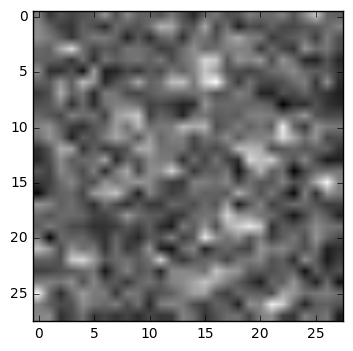

Discriminator classification [-0.00549996]


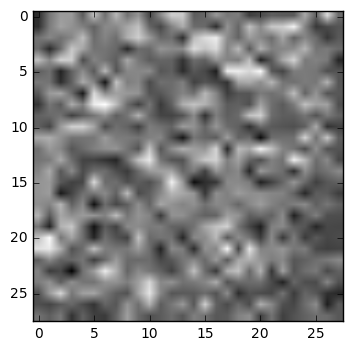

Discriminator classification [-0.00547404]


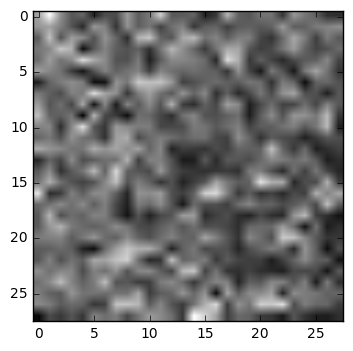

saved to models/pretrained_gan.ckpt-0
TRAINING STEP 1000 AT 2017-02-10 02:45:58.518451
Discriminator classification [-0.59628975]


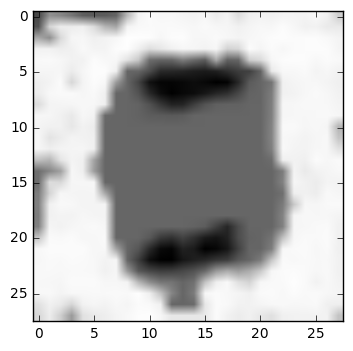

Discriminator classification [-0.62379456]


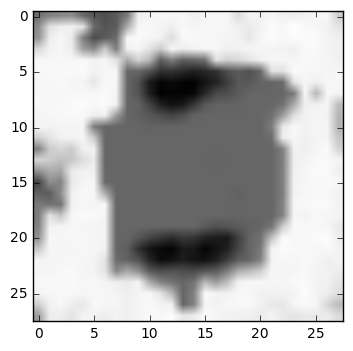

Discriminator classification [-0.54447359]


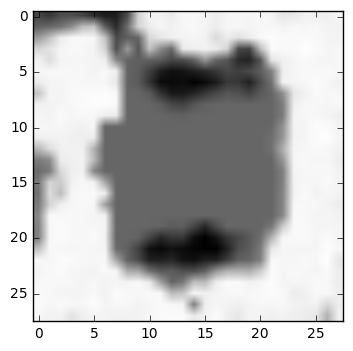

TRAINING STEP 2000 AT 2017-02-10 02:46:47.335168
Discriminator classification [-0.51694971]


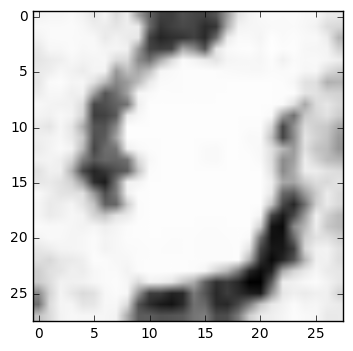

Discriminator classification [-0.45918867]


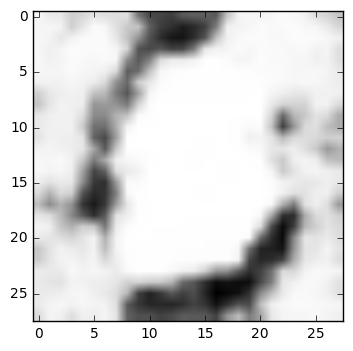

Discriminator classification [-0.32918561]


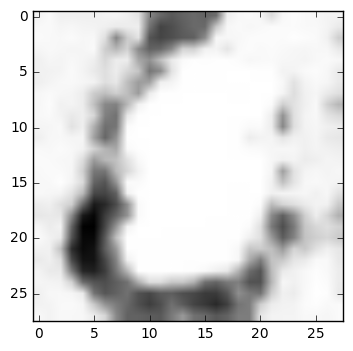

TRAINING STEP 3000 AT 2017-02-10 02:47:40.989049
Discriminator classification [-0.65458453]


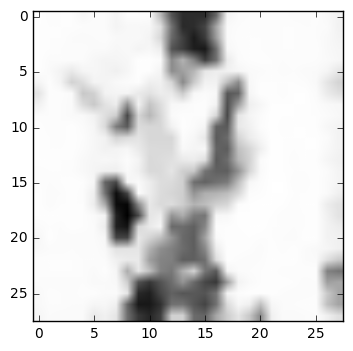

Discriminator classification [-0.54756391]


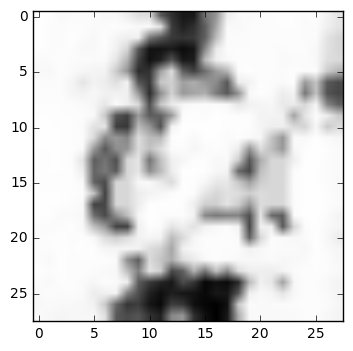

Discriminator classification [-0.30129862]


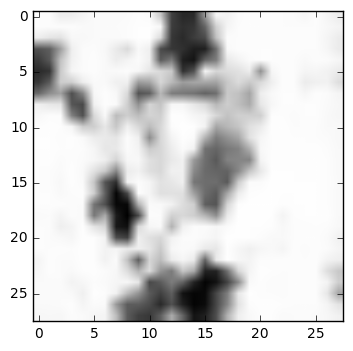

TRAINING STEP 4000 AT 2017-02-10 02:48:38.352166
Discriminator classification [ 0.23712553]


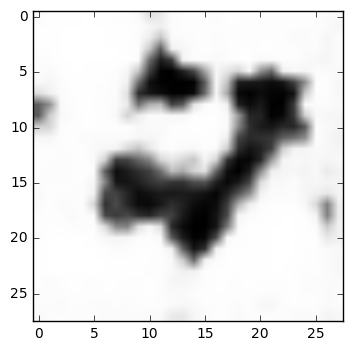

Discriminator classification [ 0.27810019]


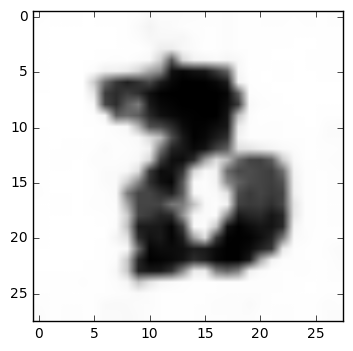

Discriminator classification [ 0.04432686]


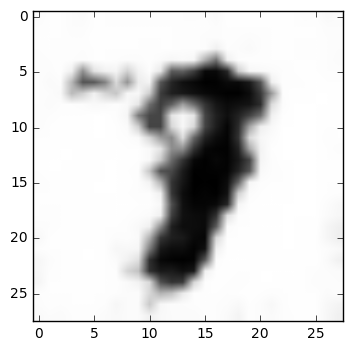

TRAINING STEP 5000 AT 2017-02-10 02:49:45.028470
Discriminator classification [-0.15720823]


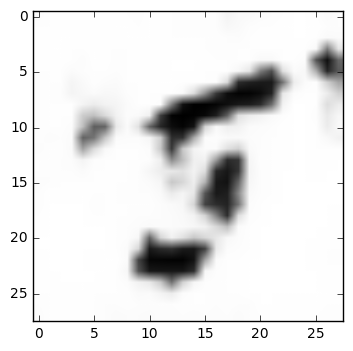

Discriminator classification [ 0.08739438]


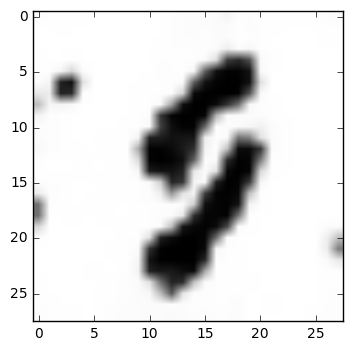

Discriminator classification [-0.17440963]


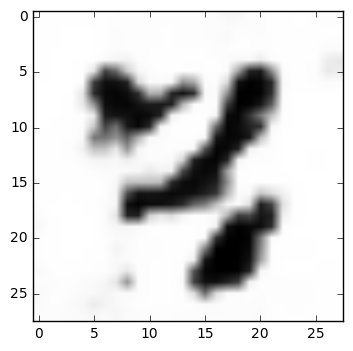

saved to models/pretrained_gan.ckpt-5000
TRAINING STEP 6000 AT 2017-02-10 02:51:00.120847
Discriminator classification [ 0.10215958]


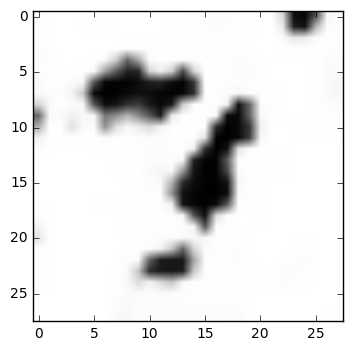

Discriminator classification [ 0.27326813]


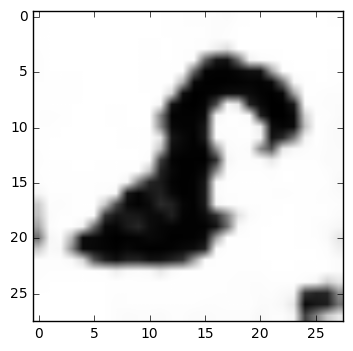

Discriminator classification [ 0.31463537]


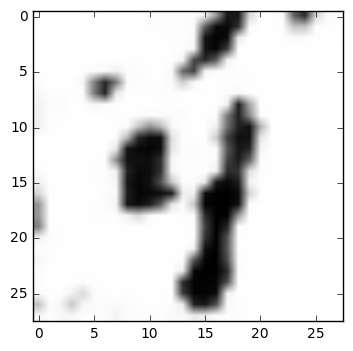

TRAINING STEP 7000 AT 2017-02-10 02:52:15.583990
Discriminator classification [ 0.28413683]


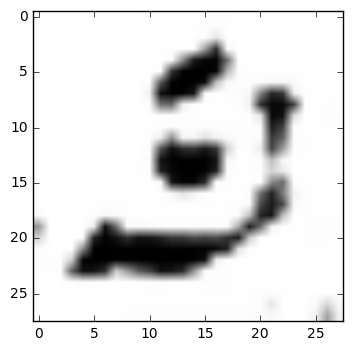

Discriminator classification [ 0.41434649]


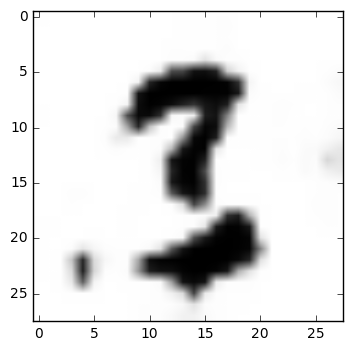

Discriminator classification [ 0.43333101]


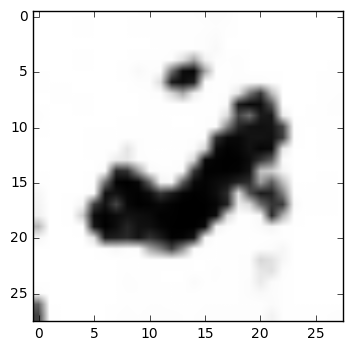

TRAINING STEP 8000 AT 2017-02-10 02:53:19.778125
Discriminator classification [ 0.13243529]


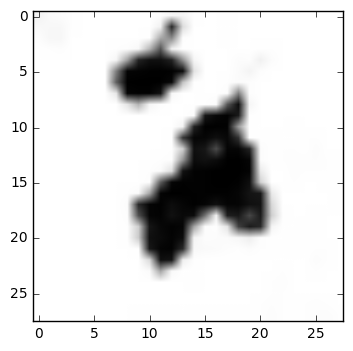

Discriminator classification [-0.08396697]


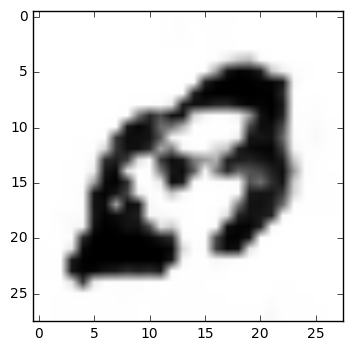

Discriminator classification [ 0.06359723]


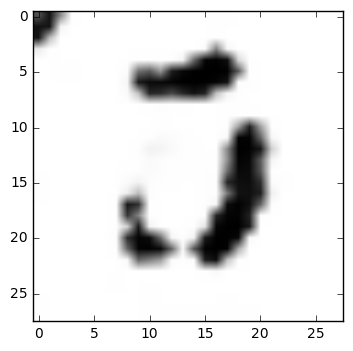

TRAINING STEP 9000 AT 2017-02-10 02:54:29.175476
Discriminator classification [-0.13717242]


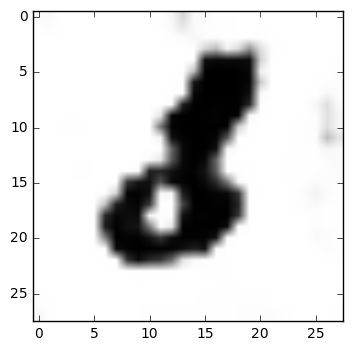

Discriminator classification [-0.0615168]


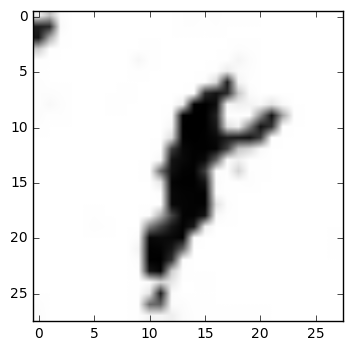

Discriminator classification [ 0.1787753]


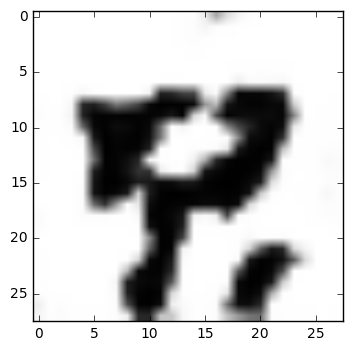

TRAINING STEP 10000 AT 2017-02-10 02:55:27.266472
Discriminator classification [ 0.47000527]


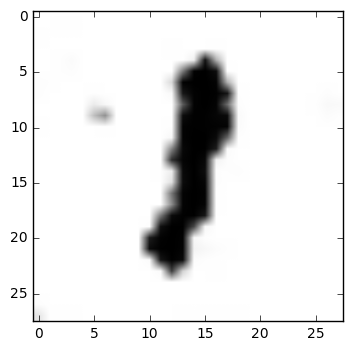

Discriminator classification [ 0.08195554]


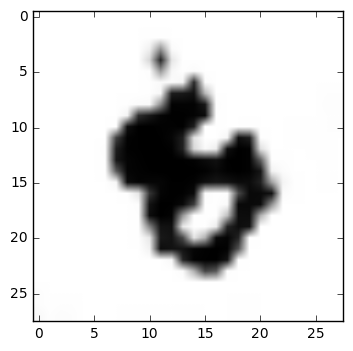

Discriminator classification [-0.05968109]


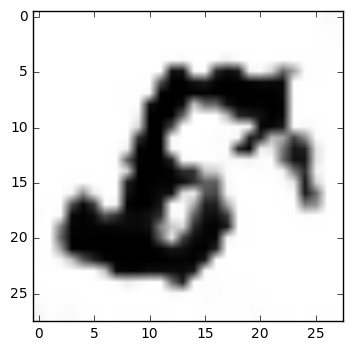

saved to models/pretrained_gan.ckpt-10000
TRAINING STEP 11000 AT 2017-02-10 02:56:26.766509
Discriminator classification [ 0.05582749]


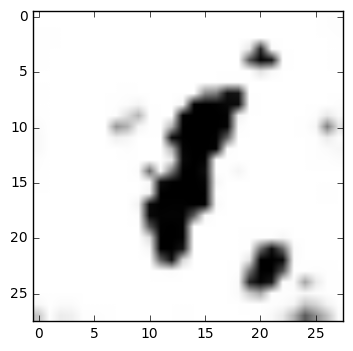

Discriminator classification [ 0.23678134]


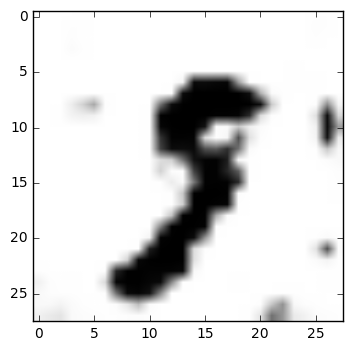

Discriminator classification [ 0.15088536]


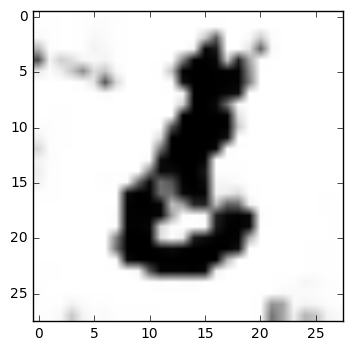

TRAINING STEP 12000 AT 2017-02-10 02:57:22.084729
Discriminator classification [ 2.2437644]


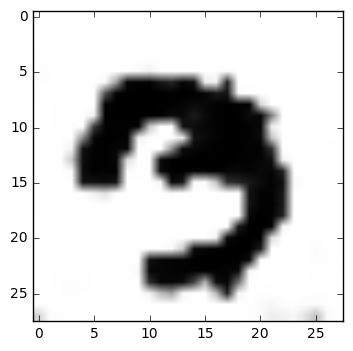

Discriminator classification [ 1.4041698]


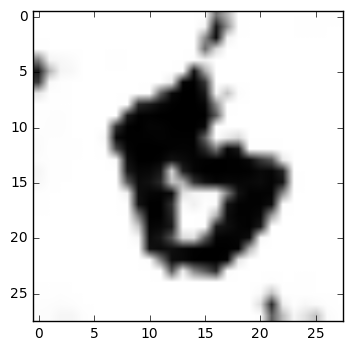

Discriminator classification [ 1.13922405]


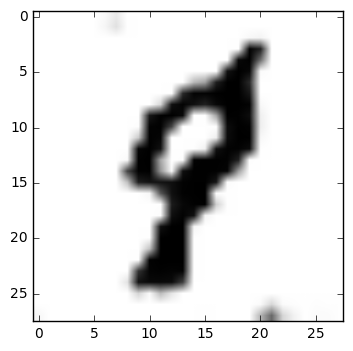

TRAINING STEP 13000 AT 2017-02-10 02:58:17.083190
Discriminator classification [ 1.86228228]


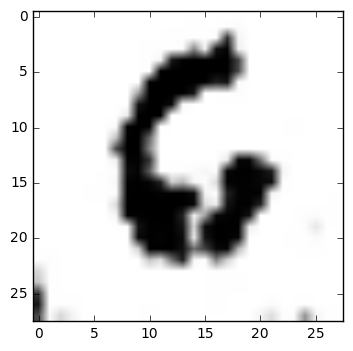

Discriminator classification [ 1.51613081]


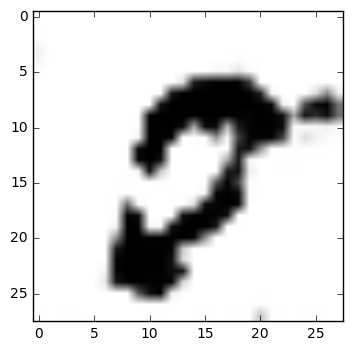

Discriminator classification [ 1.38010907]


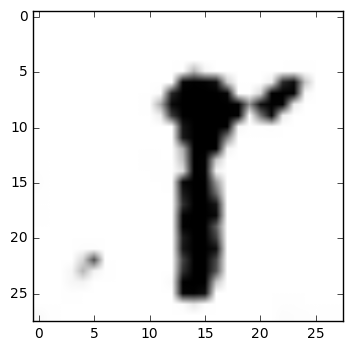

TRAINING STEP 14000 AT 2017-02-10 02:59:10.809688
Discriminator classification [ 0.98371351]


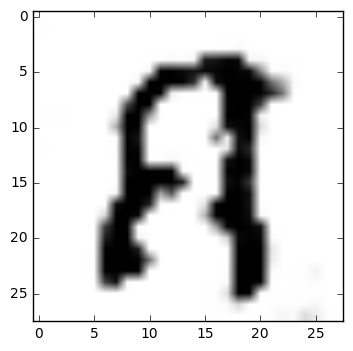

Discriminator classification [ 0.10608885]


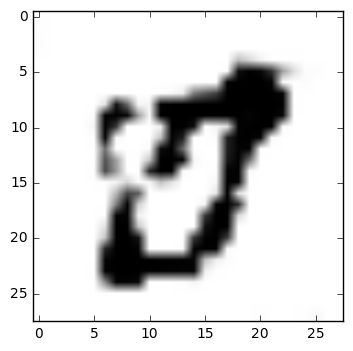

Discriminator classification [ 0.26519859]


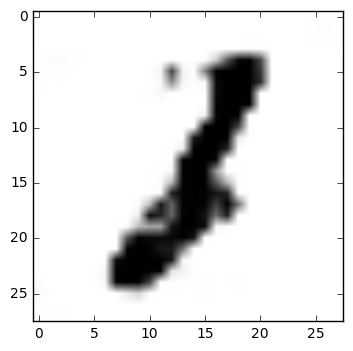

TRAINING STEP 15000 AT 2017-02-10 03:00:02.877973
Discriminator classification [ 3.8793242]


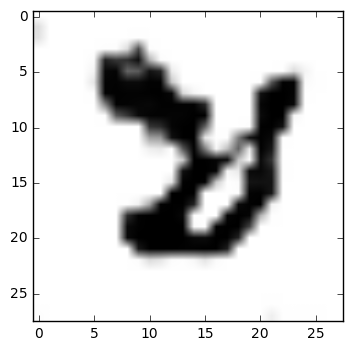

Discriminator classification [ 3.10149693]


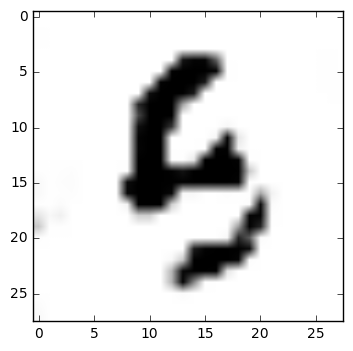

Discriminator classification [ 3.59368539]


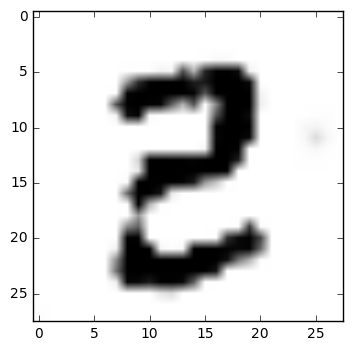

saved to models/pretrained_gan.ckpt-15000
TRAINING STEP 16000 AT 2017-02-10 03:00:58.322578
Discriminator classification [ 2.8703618]


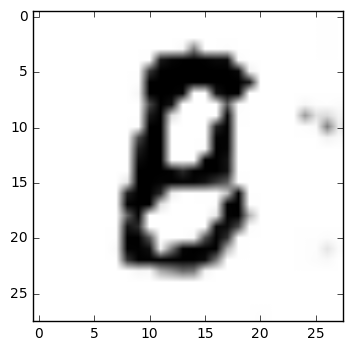

Discriminator classification [ 0.60808086]


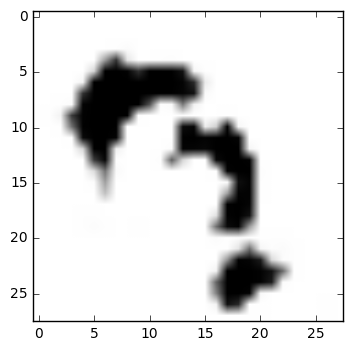

Discriminator classification [ 1.571401]


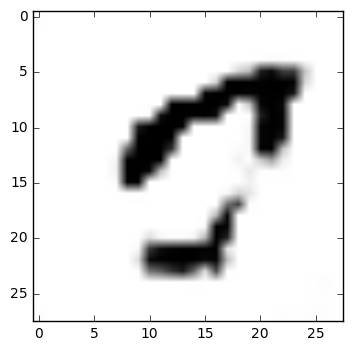

TRAINING STEP 17000 AT 2017-02-10 03:01:47.999782
Discriminator classification [ 2.79941368]


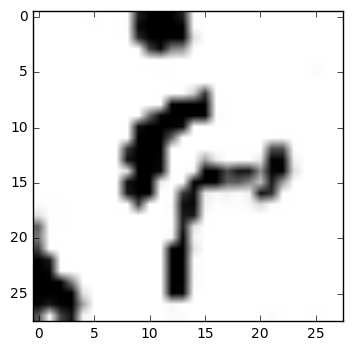

Discriminator classification [ 2.52527928]


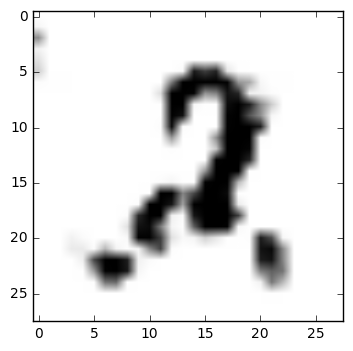

Discriminator classification [ 3.30766058]


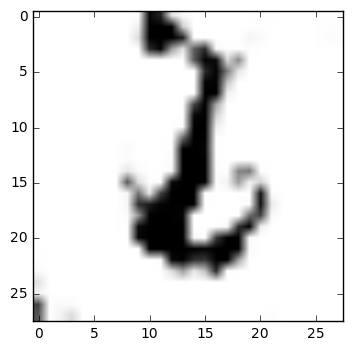

TRAINING STEP 18000 AT 2017-02-10 03:02:36.596085
Discriminator classification [ 5.18805218]


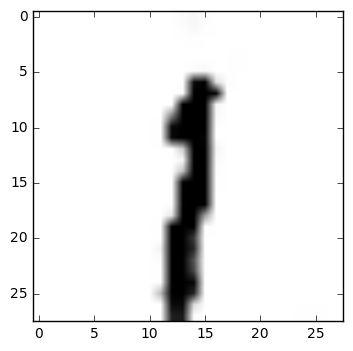

Discriminator classification [ 4.04936838]


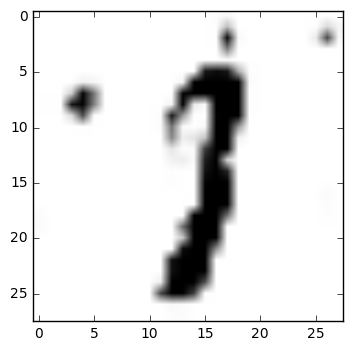

Discriminator classification [ 4.51349163]


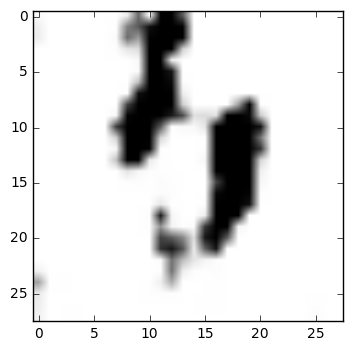

TRAINING STEP 19000 AT 2017-02-10 03:03:25.010422
Discriminator classification [ 3.72640419]


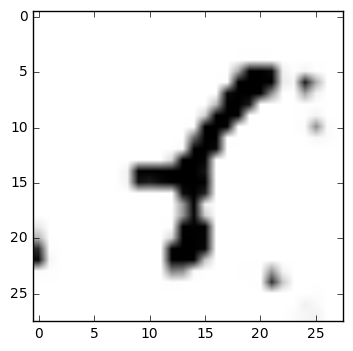

Discriminator classification [ 7.5231266]


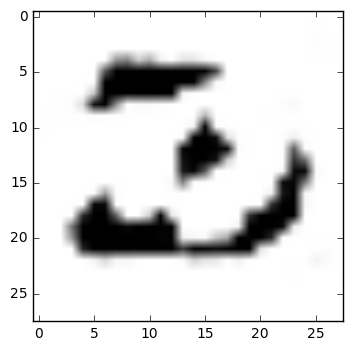

Discriminator classification [ 4.72235489]


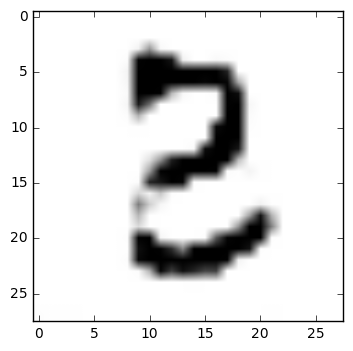

TRAINING STEP 20000 AT 2017-02-10 03:04:13.402290
Discriminator classification [ 2.24984384]


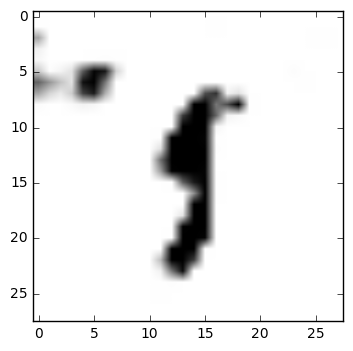

Discriminator classification [ 10.12364388]


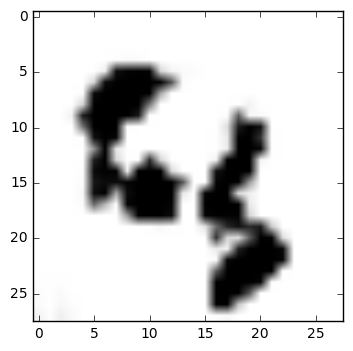

Discriminator classification [ 3.45375943]


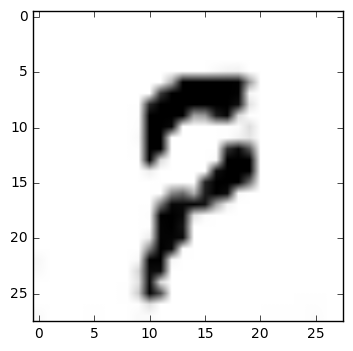

saved to models/pretrained_gan.ckpt-20000
TRAINING STEP 21000 AT 2017-02-10 03:05:06.424408
Discriminator classification [-0.29962337]


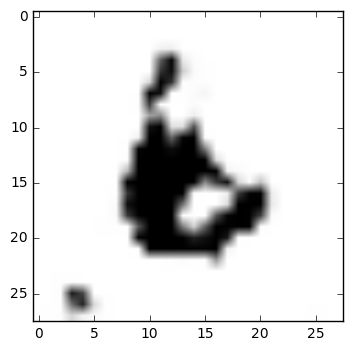

Discriminator classification [ 1.14983153]


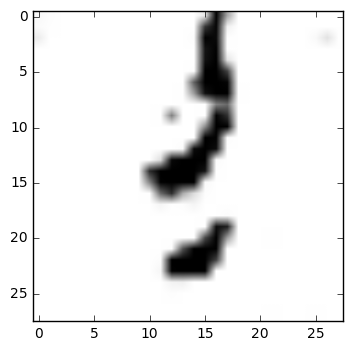

Discriminator classification [ 5.56508684]


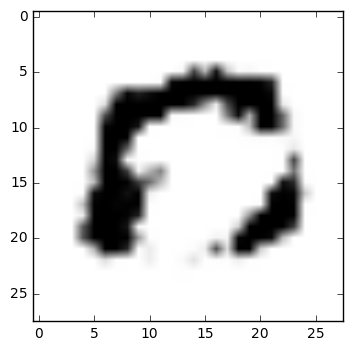

TRAINING STEP 22000 AT 2017-02-10 03:05:55.160027
Discriminator classification [ 9.45695305]


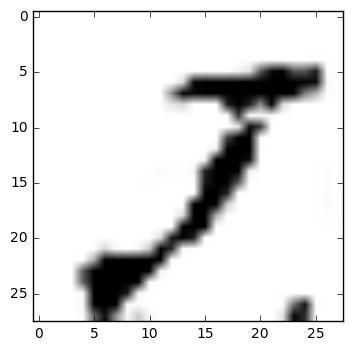

Discriminator classification [ 3.87063193]


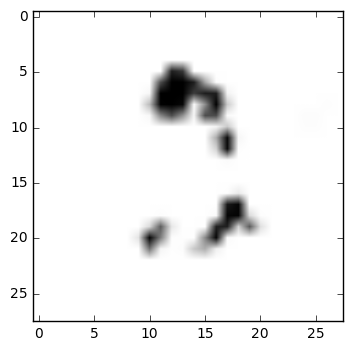

Discriminator classification [ 6.3560257]


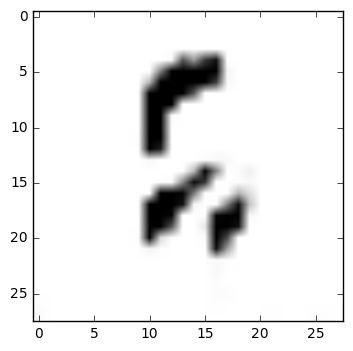

TRAINING STEP 23000 AT 2017-02-10 03:06:43.606733
Discriminator classification [ 4.64468193]


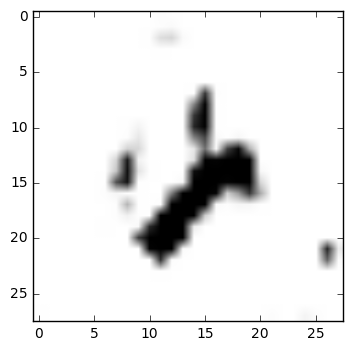

Discriminator classification [ 4.2761488]


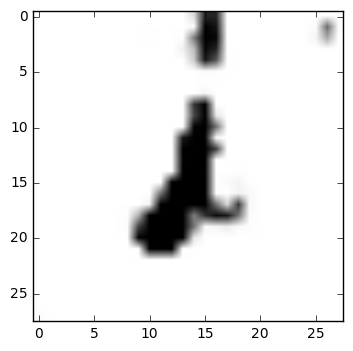

Discriminator classification [ 12.10780525]


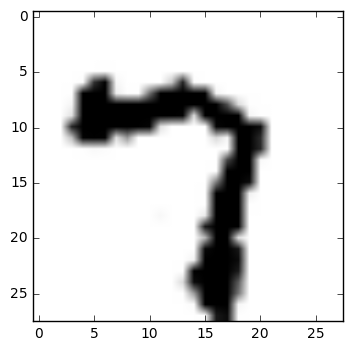

TRAINING STEP 24000 AT 2017-02-10 03:07:32.265163
Discriminator classification [-4.62071896]


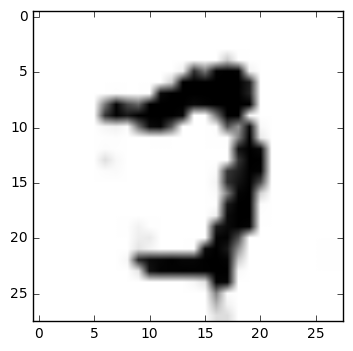

Discriminator classification [-3.30187607]


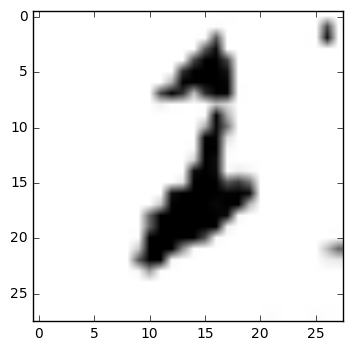

Discriminator classification [-2.19228315]


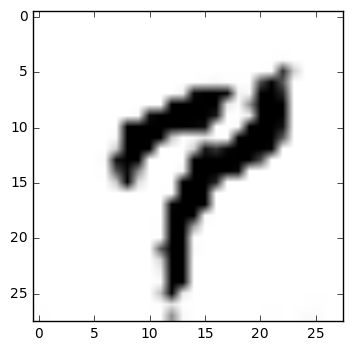

TRAINING STEP 25000 AT 2017-02-10 03:08:21.562172
Discriminator classification [ 2.04929781]


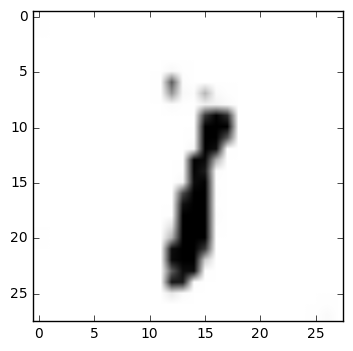

Discriminator classification [ 7.32217407]


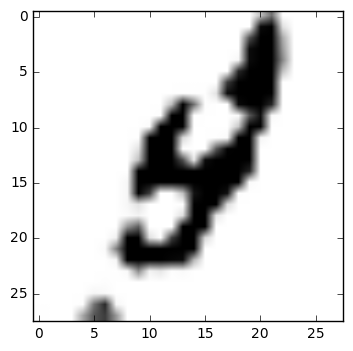

Discriminator classification [ 3.34303212]


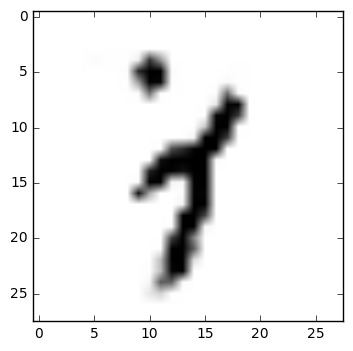

saved to models/pretrained_gan.ckpt-25000
TRAINING STEP 26000 AT 2017-02-10 03:09:16.248203
Discriminator classification [ 5.02476025]


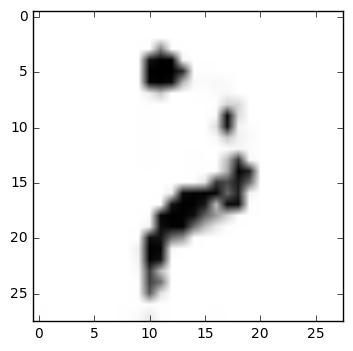

Discriminator classification [ 4.88428545]


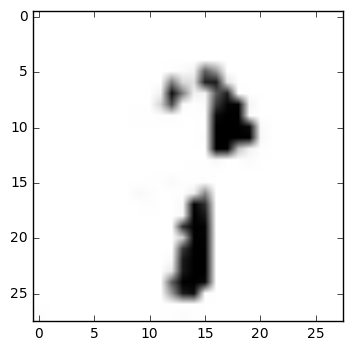

Discriminator classification [ 5.57817316]


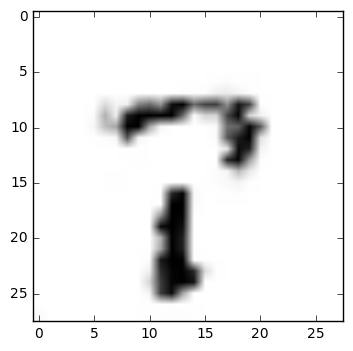

TRAINING STEP 27000 AT 2017-02-10 03:10:05.961033
Discriminator classification [-4.79989958]


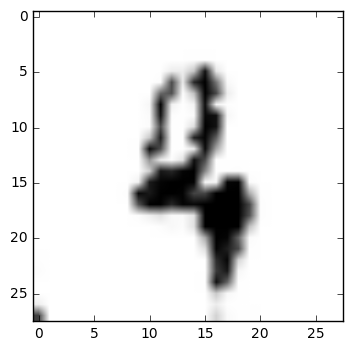

Discriminator classification [-3.88045955]


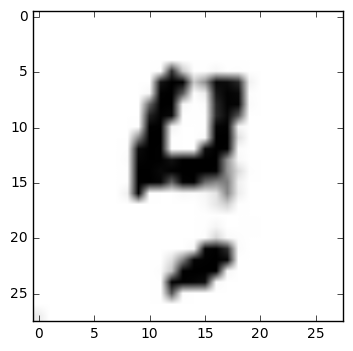

Discriminator classification [-5.00514221]


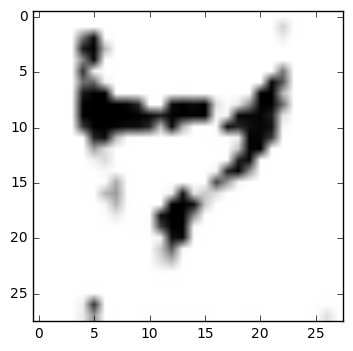

TRAINING STEP 28000 AT 2017-02-10 03:10:55.671885
Discriminator classification [ 6.3808136]


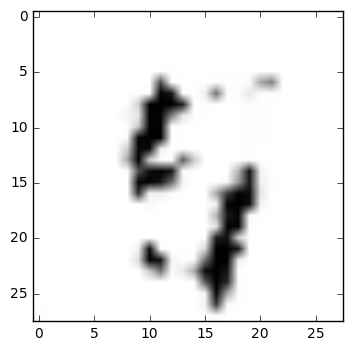

Discriminator classification [ 5.58633614]


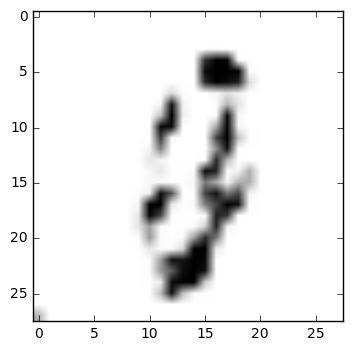

Discriminator classification [ 6.18097544]


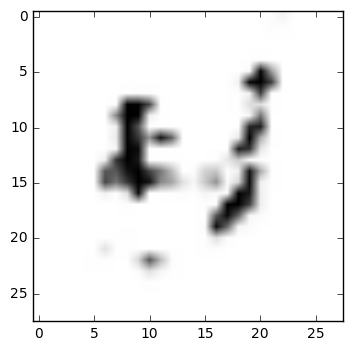

TRAINING STEP 29000 AT 2017-02-10 03:11:45.162447
Discriminator classification [ 2.27635598]


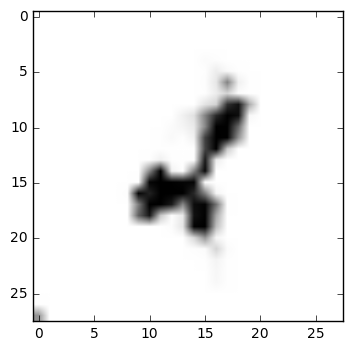

Discriminator classification [ 5.40979528]


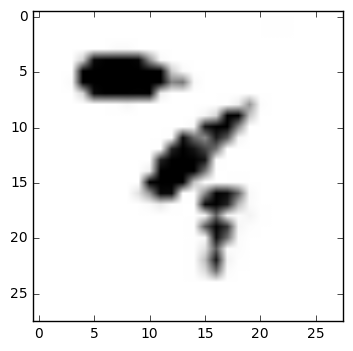

Discriminator classification [ 3.92909503]


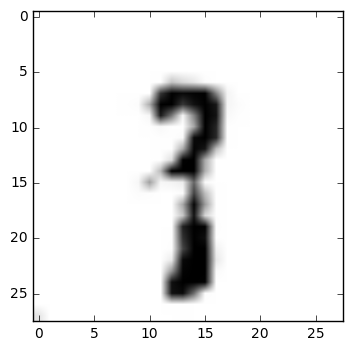

TRAINING STEP 30000 AT 2017-02-10 03:12:34.626508
Discriminator classification [ 3.48442435]


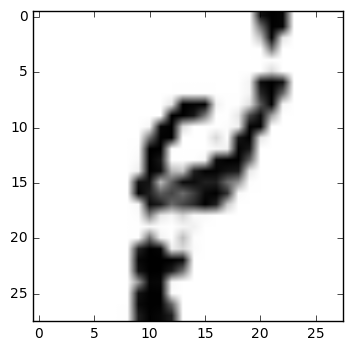

Discriminator classification [ 0.76482511]


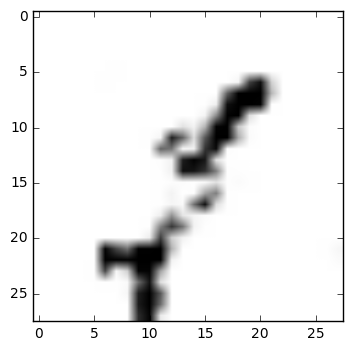

Discriminator classification [ 1.91804838]


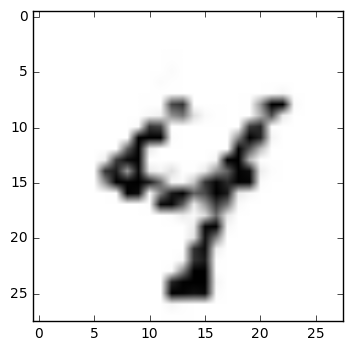

saved to models/pretrained_gan.ckpt-30000
TRAINING STEP 31000 AT 2017-02-10 03:13:29.724071
Discriminator classification [ 2.13316631]


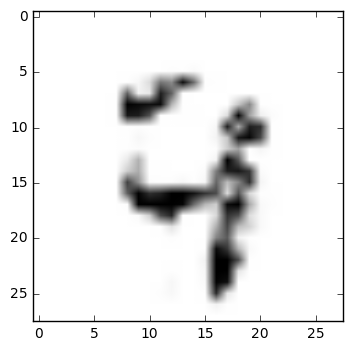

Discriminator classification [ 2.4702599]


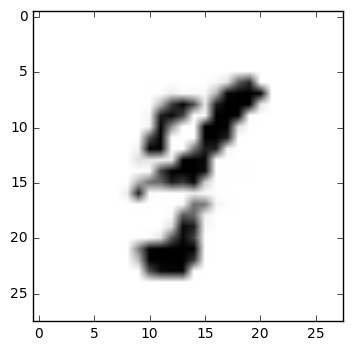

Discriminator classification [ 3.15506697]


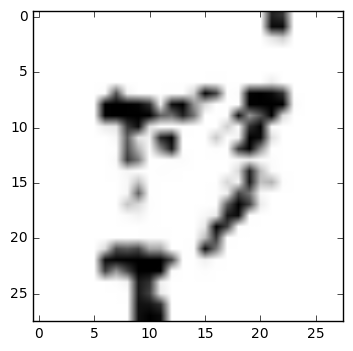

TRAINING STEP 32000 AT 2017-02-10 03:14:19.611497
Discriminator classification [ 2.03638434]


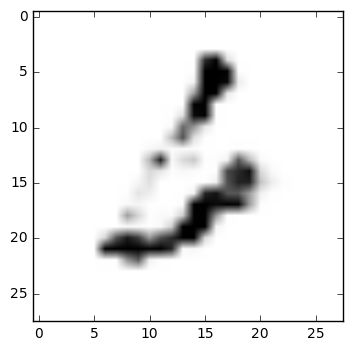

Discriminator classification [ 2.98405719]


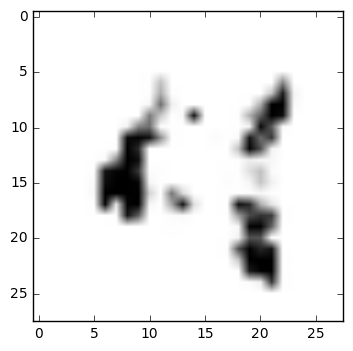

Discriminator classification [ 3.72933745]


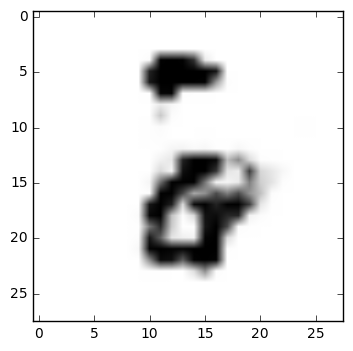

TRAINING STEP 33000 AT 2017-02-10 03:15:09.526147
Discriminator classification [-3.89107299]


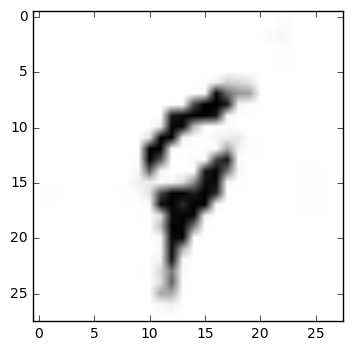

Discriminator classification [-2.32203579]


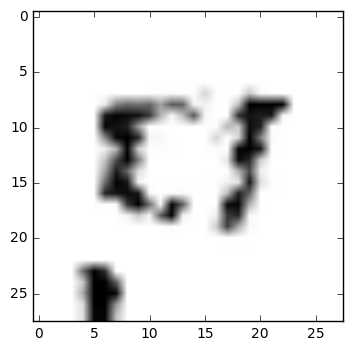

Discriminator classification [-3.57337761]


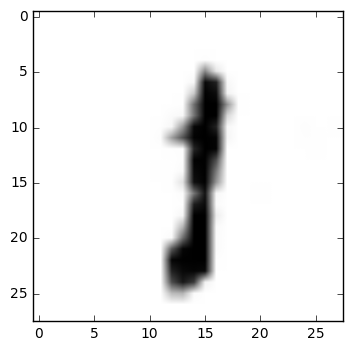

TRAINING STEP 34000 AT 2017-02-10 03:15:59.434516
Discriminator classification [ 9.28799534]


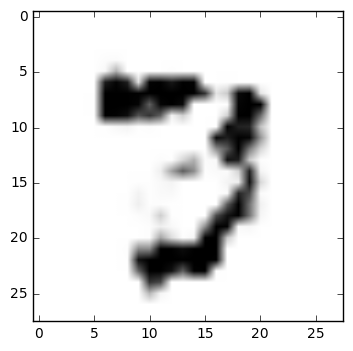

Discriminator classification [ 5.45718193]


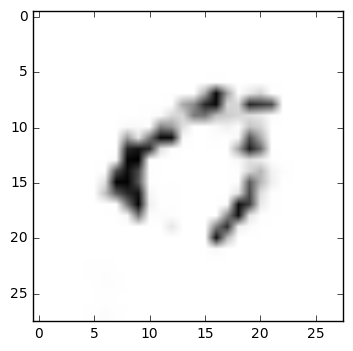

Discriminator classification [ 8.34229183]


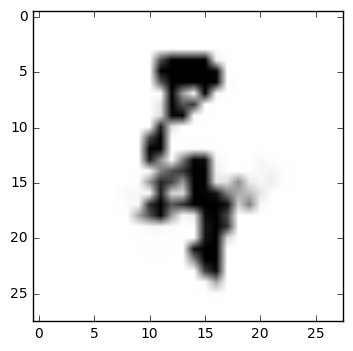

TRAINING STEP 35000 AT 2017-02-10 03:16:49.222766
Discriminator classification [ 0.55266428]


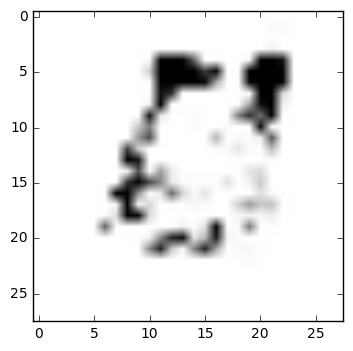

Discriminator classification [ 1.15335739]


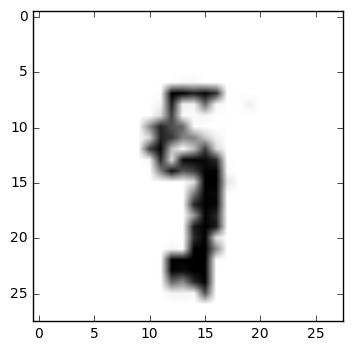

Discriminator classification [ 3.58046556]


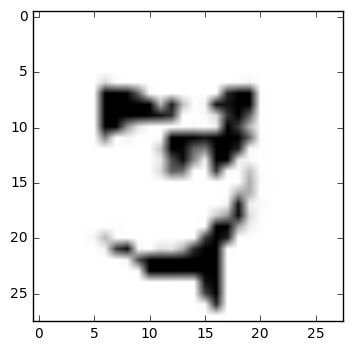

saved to models/pretrained_gan.ckpt-35000
TRAINING STEP 36000 AT 2017-02-10 03:17:45.156415
Discriminator classification [-1.72521567]


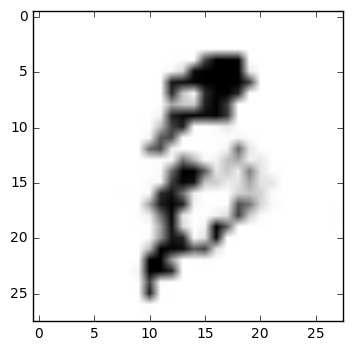

Discriminator classification [-1.89111435]


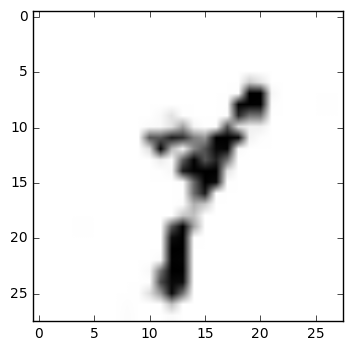

Discriminator classification [-3.97743058]


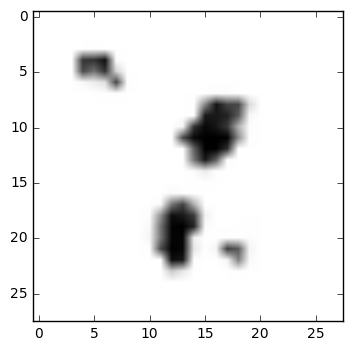

TRAINING STEP 37000 AT 2017-02-10 03:18:35.343804
Discriminator classification [ 6.02440453]


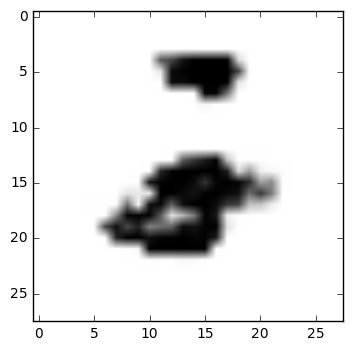

Discriminator classification [ 6.49565458]


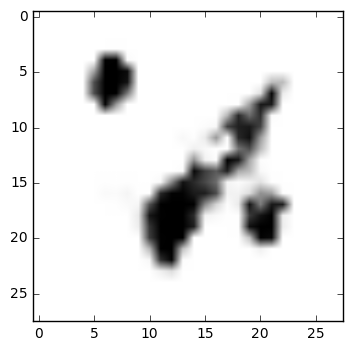

Discriminator classification [ 5.40898848]


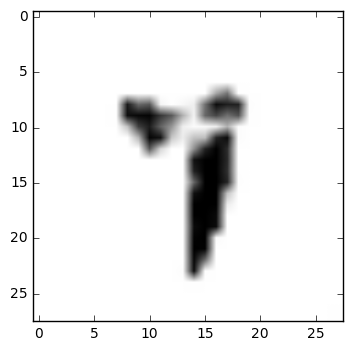

TRAINING STEP 38000 AT 2017-02-10 03:19:25.371947
Discriminator classification [ 4.7186265]


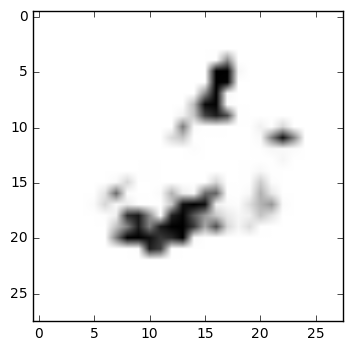

Discriminator classification [ 4.66377163]


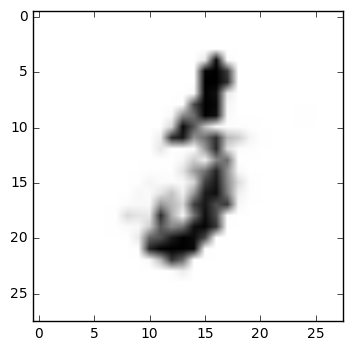

Discriminator classification [ 7.83346844]


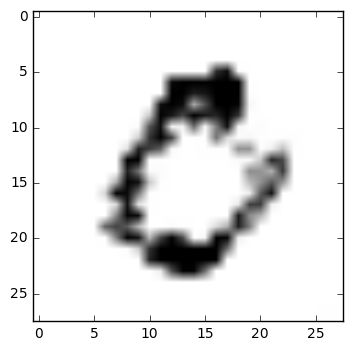

TRAINING STEP 39000 AT 2017-02-10 03:20:15.353849
Discriminator classification [ 0.20930231]


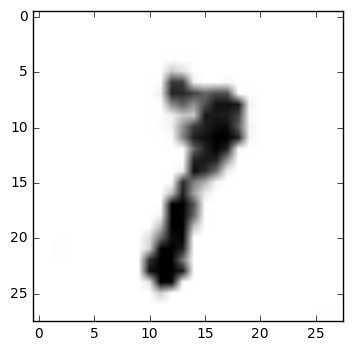

Discriminator classification [-0.24991468]


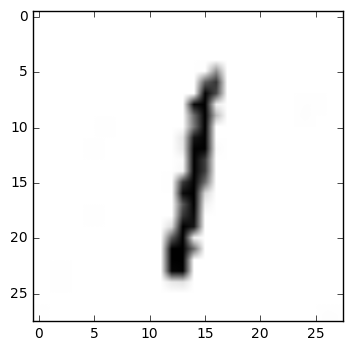

Discriminator classification [ 1.64575648]


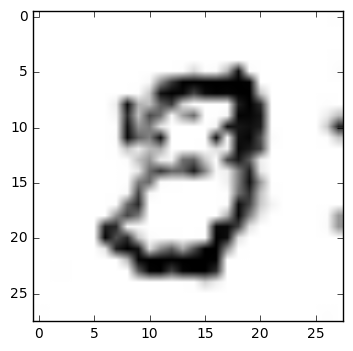

TRAINING STEP 40000 AT 2017-02-10 03:21:05.263181
Discriminator classification [ 1.83689094]


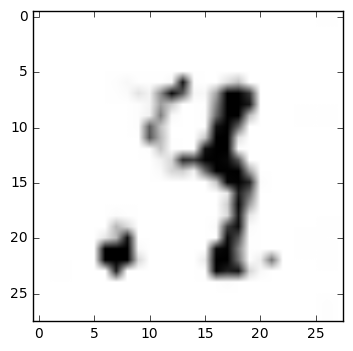

Discriminator classification [ 0.35527343]


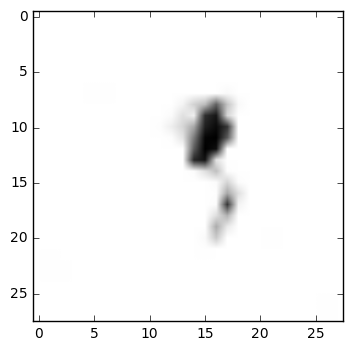

Discriminator classification [ 8.00728416]


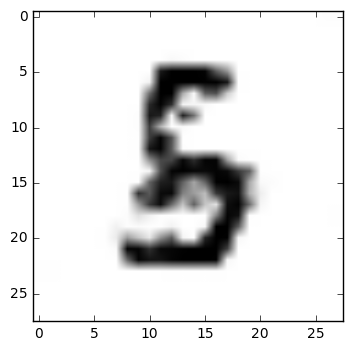

saved to models/pretrained_gan.ckpt-40000
TRAINING STEP 41000 AT 2017-02-10 03:22:02.083267
Discriminator classification [ 0.79651982]


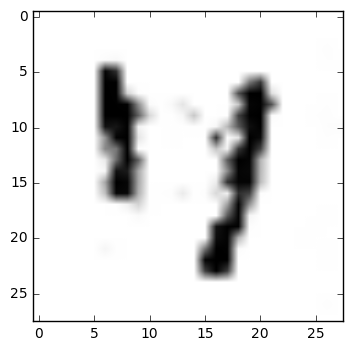

Discriminator classification [ 1.04572392]


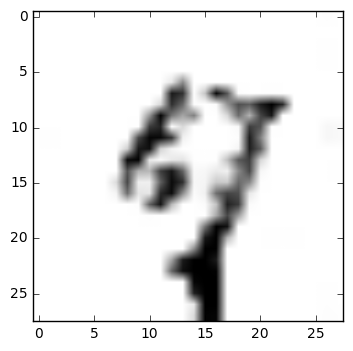

Discriminator classification [ 0.33060914]


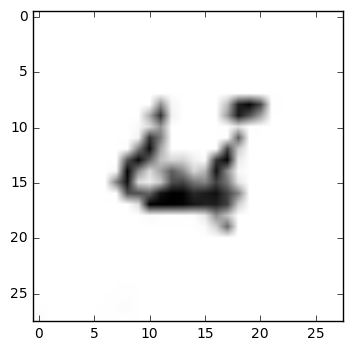

TRAINING STEP 42000 AT 2017-02-10 03:22:52.103501
Discriminator classification [ 7.91911602]


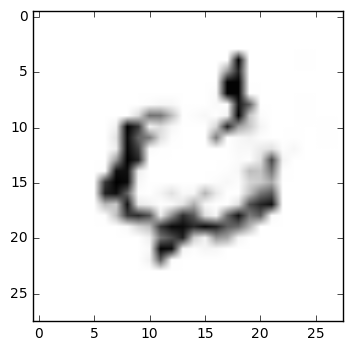

Discriminator classification [ 9.52223206]


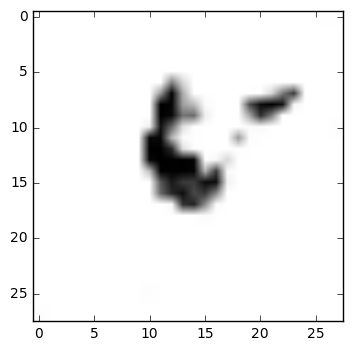

Discriminator classification [ 8.90988541]


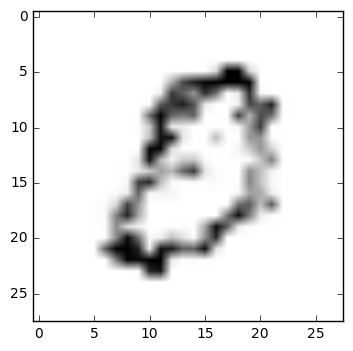

TRAINING STEP 43000 AT 2017-02-10 03:23:41.936276
Discriminator classification [ 4.4936409]


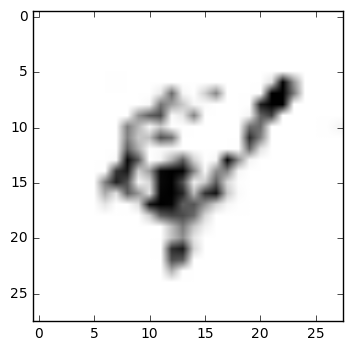

Discriminator classification [ 2.25289035]


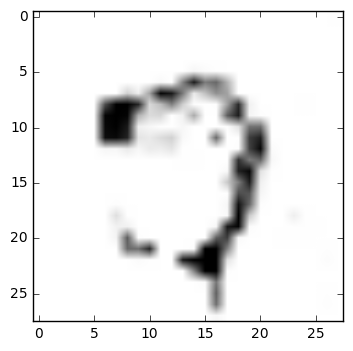

Discriminator classification [ 0.94561869]


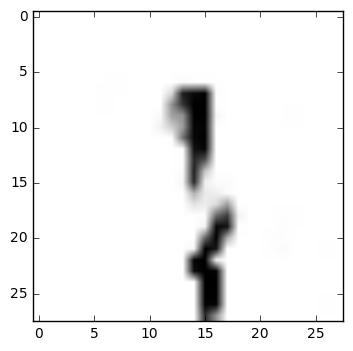

TRAINING STEP 44000 AT 2017-02-10 03:24:31.353752
Discriminator classification [ 2.11202741]


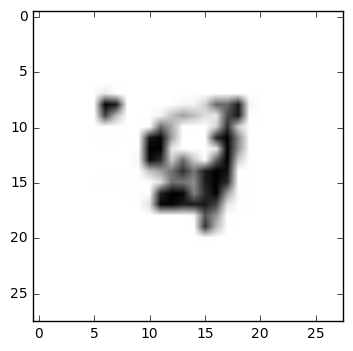

Discriminator classification [ 2.42781115]


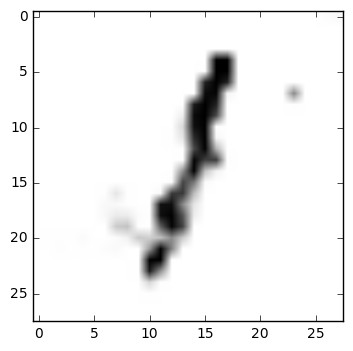

Discriminator classification [ 4.57453394]


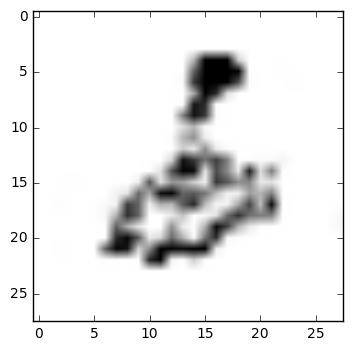

TRAINING STEP 45000 AT 2017-02-10 03:25:20.685157
Discriminator classification [ 2.58475804]


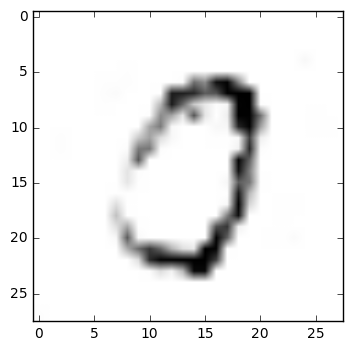

Discriminator classification [-0.08796293]


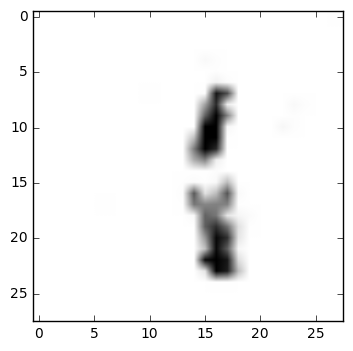

Discriminator classification [ 1.2933923]


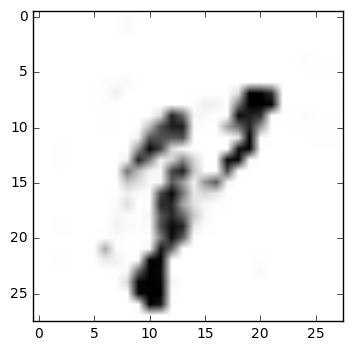

saved to models/pretrained_gan.ckpt-45000
TRAINING STEP 46000 AT 2017-02-10 03:26:16.375790
Discriminator classification [ 5.17579746]


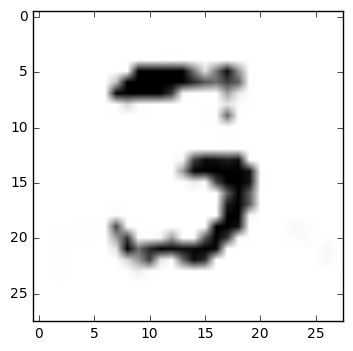

Discriminator classification [ 4.76106691]


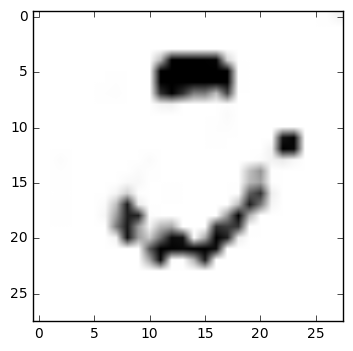

Discriminator classification [ 5.05691338]


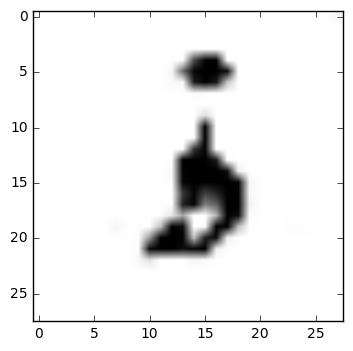

TRAINING STEP 47000 AT 2017-02-10 03:27:06.492541
Discriminator classification [ 8.99238586]


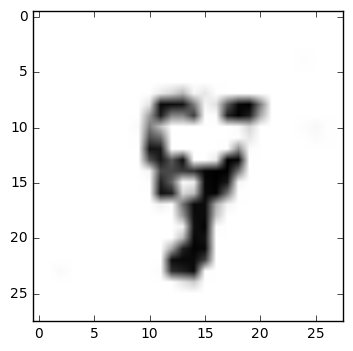

Discriminator classification [ 6.09860945]


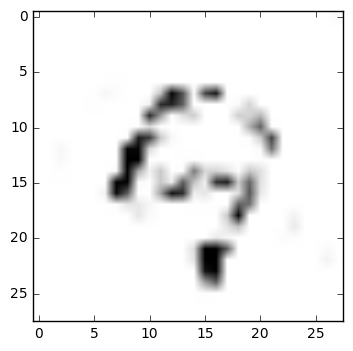

Discriminator classification [ 8.51457977]


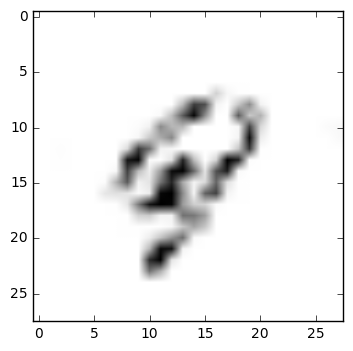

TRAINING STEP 48000 AT 2017-02-10 03:27:56.211907
Discriminator classification [ 4.25298405]


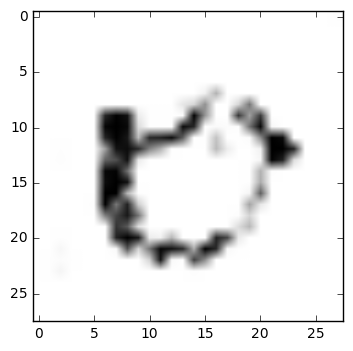

Discriminator classification [ 3.04585266]


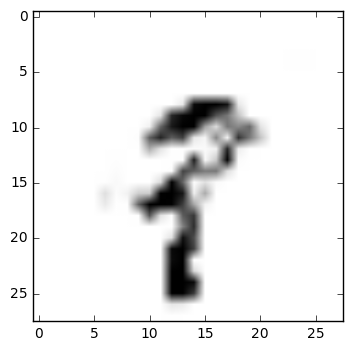

Discriminator classification [ 0.14106646]


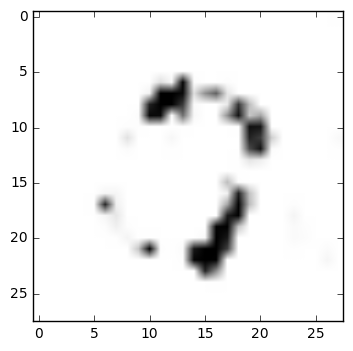

TRAINING STEP 49000 AT 2017-02-10 03:28:46.036440
Discriminator classification [ 1.57191765]


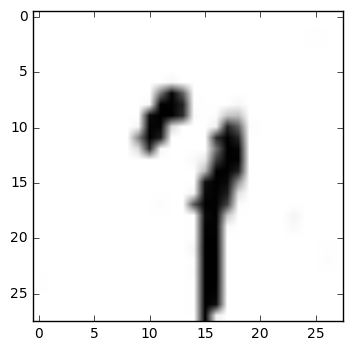

Discriminator classification [ 2.27450013]


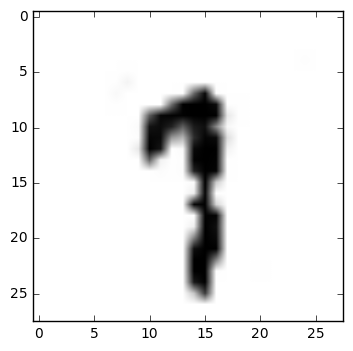

Discriminator classification [ 0.95506871]


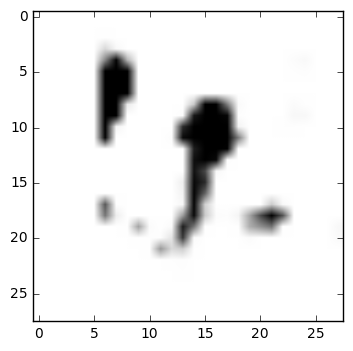

In [6]:
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

gLoss = 0
dLossFake, dLossReal = 1, 1
d_real_count, d_fake_count, g_count = 0, 0, 0
for i in range(50000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    if dLossFake > 0.5:
        # Train discriminator on generated images
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_fake, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_fake_count += 1

    if gLoss > 0.5:
        # Train the generator
        _, dLossReal, dLossFake, gLoss = sess.run([g_trainer, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        g_count += 1

    if dLossReal > 0.45:
        # If the discriminator classifies real images as fake,
        # train discriminator on real values
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_real, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_real_count += 1

    if i % 10 == 0:
        real_image_batch = mnist.validation.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        summary = sess.run(merged, {x_placeholder: real_image_batch, d_real_count_ph: d_real_count,
                                    d_fake_count_ph: d_fake_count, g_count_ph: g_count})
        writer.add_summary(summary, i)
        d_real_count, d_fake_count, g_count = 0, 0, 0

    if i % 1000 == 0:
        # Periodically display a sample image in the notebook
        # (These are also being sent to TensorBoard every 10 iterations)
        images = sess.run(generator(3, z_dimensions))
        d_result = sess.run(discriminator(x_placeholder), {x_placeholder: images})
        print("TRAINING STEP", i, "AT", datetime.datetime.now())
        for j in range(3):
            print("Discriminator classification", d_result[j])
            im = images[j, :, :, 0]
            plt.imshow(im.reshape([28, 28]), cmap='Greys')
            plt.show()

    if i % 5000 == 0:
        save_path = saver.save(sess, "models/pretrained_gan.ckpt", global_step=i)
        print("saved to %s" % save_path)

Now let's see some of the images produced by the generator. (The generator has also been sending its images to TensorBoard regularly; click the "images" tab in TensorBoard to see them as this runs.)

And, as a sanity check, let's look at some real MNIST images and make sure that the discriminator correctly classifies them as real MINST images.

[ 10.58191395]


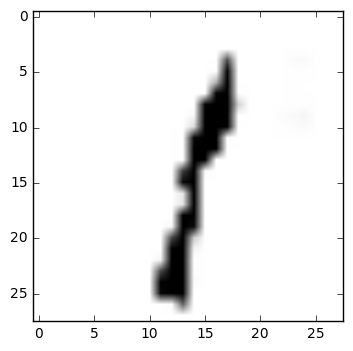

[ 9.85821915]


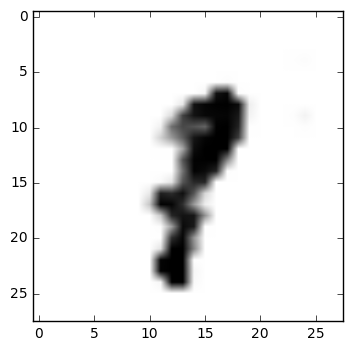

[ 9.24966717]


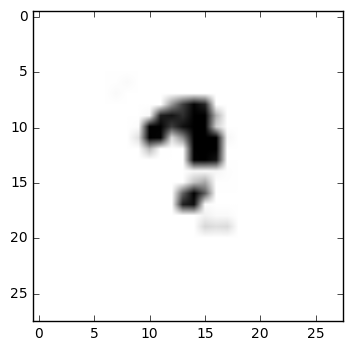

[ 11.93396568]


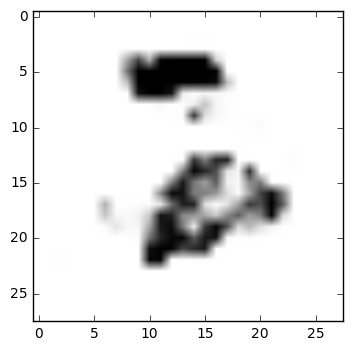

[ 10.78705788]


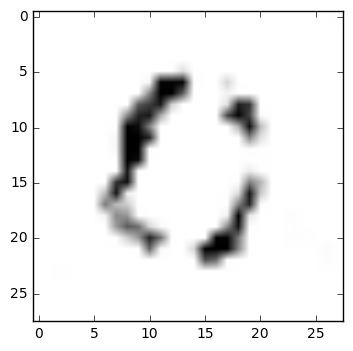

[ 11.75609398]


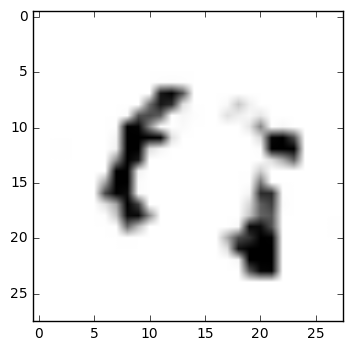

[ 11.77258968]


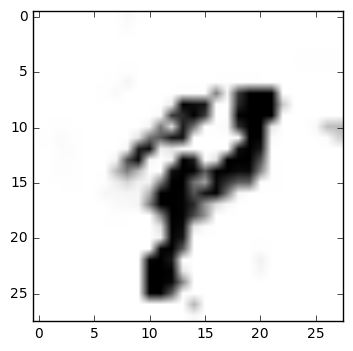

[ 12.32115173]


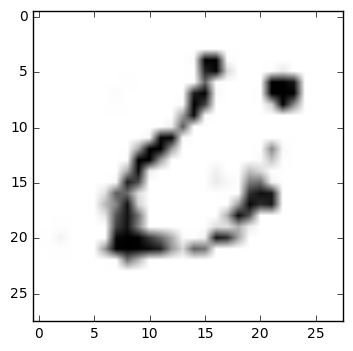

[ 10.44042873]


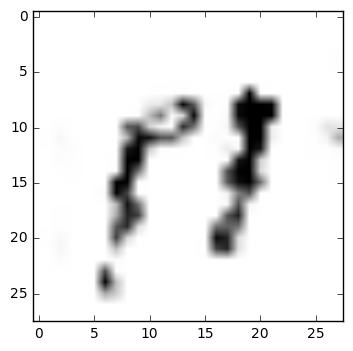

[ 9.74366283]


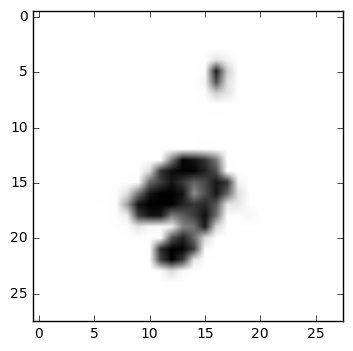

[ 13.56807041]


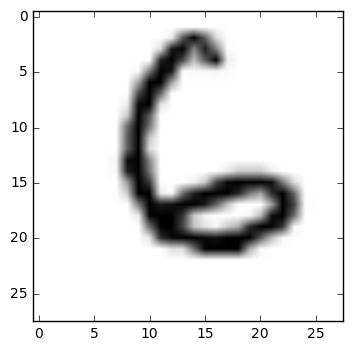

[ 11.63399792]


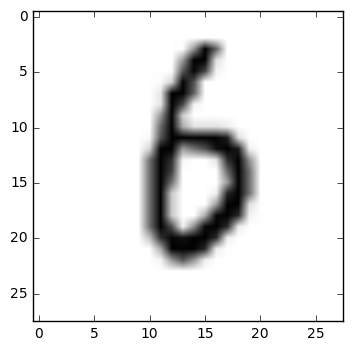

[ 17.88589478]


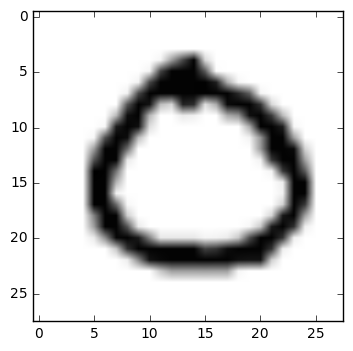

[ 10.74034882]


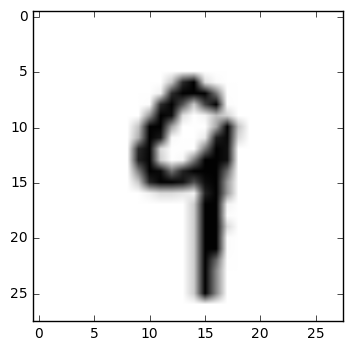

[ 19.86901474]


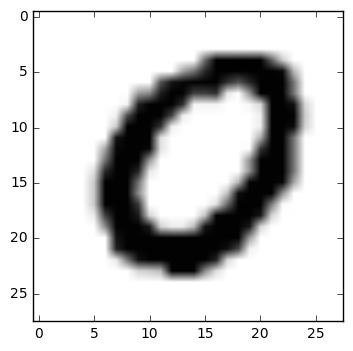

[ 9.43930054]


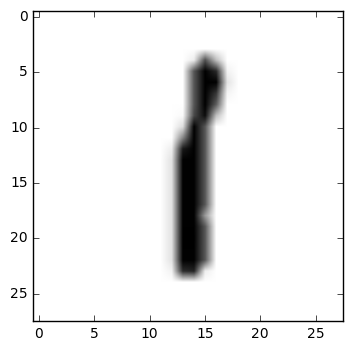

[ 11.75360012]


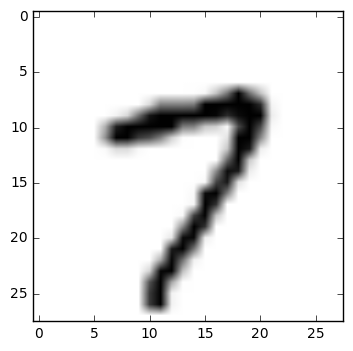

[ 11.44880772]


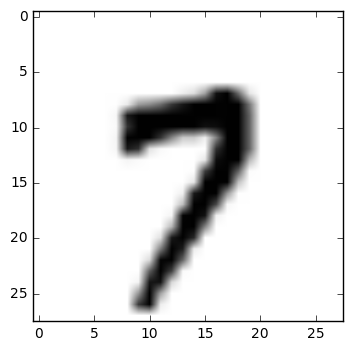

[ 10.48155975]


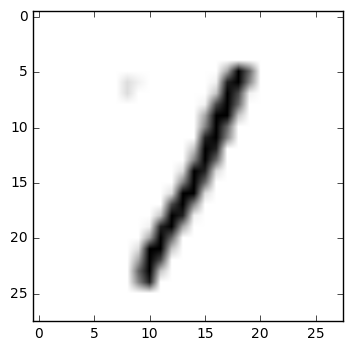

[ 16.69826889]


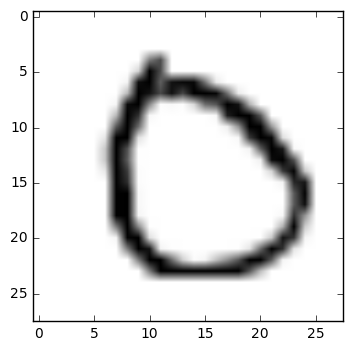

In [7]:
test_images = sess.run(generator(10, 100))
test_eval = sess.run(discriminator(x_placeholder), {x_placeholder: test_images})

real_images = mnist.validation.next_batch(10)[0].reshape([10, 28, 28, 1])
real_eval = sess.run(discriminator(x_placeholder), {x_placeholder: real_images})

# Show discriminator's probabilities for the generated images,
# and display the images
for i in range(10):
    print(test_eval[i])
    plt.imshow(test_images[i, :, :, 0], cmap='Greys')
    plt.show()

# Now do the same for real MNIST images
for i in range(10):
    print(real_eval[i])
    plt.imshow(real_images[i, :, :, 0], cmap='Greys')
    plt.show()